<a href="https://colab.research.google.com/github/Dstri26/SeTra/blob/main/Notebooks/Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/food41
!mkdir food
!unzip food41.zip -d food

Streaming output truncated to the last 5000 lines.
  inflating: food/images/tacos/1026681.jpg  
  inflating: food/images/tacos/1030289.jpg  
  inflating: food/images/tacos/1033196.jpg  
  inflating: food/images/tacos/1036030.jpg  
  inflating: food/images/tacos/1042175.jpg  
  inflating: food/images/tacos/1044043.jpg  
  inflating: food/images/tacos/1058697.jpg  
  inflating: food/images/tacos/1059239.jpg  
  inflating: food/images/tacos/1059326.jpg  
  inflating: food/images/tacos/1066762.jpg  
  inflating: food/images/tacos/1070967.jpg  
  inflating: food/images/tacos/1073468.jpg  
  inflating: food/images/tacos/1075296.jpg  
  inflating: food/images/tacos/1085243.jpg  
  inflating: food/images/tacos/108529.jpg  
  inflating: food/images/tacos/1086014.jpg  
  inflating: food/images/tacos/108945.jpg  
  inflating: food/images/tacos/1089575.jpg  
  inflating: food/images/tacos/1091159.jpg  
  inflating: food/images/tacos/1101369.jpg  
  inflating: food/images/tacos/1109058.jpg  
  infl

In [2]:
import os
for i in os.listdir('food'):
  if '.h5' in i:
    os.remove('food/' + i)

In [3]:
foods = ['cheesecake', 'chicken_curry', 'donuts', 'french_fries', 'fried_rice',
         'omelette', 'pizza', 'samosa', 'grilled_cheese_sandwich', 'ice_cream']

In [4]:
import shutil
for i in os.listdir('food/images'):
  if i in foods:
    continue
  else:
    shutil.rmtree('food/images/' + i)

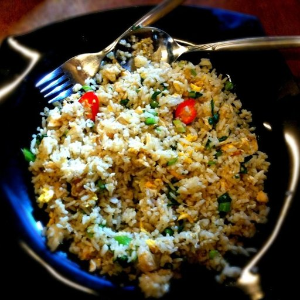

(512, 512, 3)


In [5]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/food/images/fried_rice/1008935.jpg')
cv2_imshow(cv2.resize(img, (300, 300)))
print(img.shape)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import activations
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import cv2

In [7]:
from keras.preprocessing.image import ImageDataGenerator
image_data = ImageDataGenerator(rescale = 1./255,
                                      shear_range = 0.1,
                                      zoom_range = 0.2,
                                      #rotation_range = 30,
                                      #horizontal_flip = True,
                                      validation_split = 0.2)

In [8]:
train_generator = image_data.flow_from_directory("/content/food/images",
                                                       target_size = (300, 300),
                                                       batch_size = 32,
                                                       class_mode = 'categorical',
                                                       subset = 'training')
test_generator = image_data.flow_from_directory("/content/food/images",
                                                    target_size = (300, 300),
                                                    batch_size = 32,
                                                    class_mode ='categorical',                                          
                                                    subset = 'validation')

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [46]:
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
tl_model = tf.keras.applications.DenseNet201(weights='imagenet', 
                                                     include_top = False, 
                                                     input_shape = (300, 300, 3), 
                                                     pooling='max')

In [47]:
for layer in tl_model.layers[0:-10]:
  layer.trainable = False

In [48]:
tl_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_10 (ZeroPadding2 (None, 306, 306, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 150, 150, 64) 9408        zero_padding2d_10[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [49]:
model = models.Sequential([tl_model,
                           layers.Dense(1024, activation = 'relu'),
                           layers.Dropout(0.2),
                           layers.Dense(512, activation = 'relu'),
                           layers.Dropout(0.2),
                           layers.Dense(256, activation = 'relu'),
                           layers.Dropout(0.25),
                           layers.Dense(10, activation='softmax')])

In [50]:
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

optimizer = tf.keras.optimizers.Adam(lr = 0.001)
model.compile(loss='categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-7, verbose=1)

In [51]:
history = model.fit(train_generator,
                    validation_data = test_generator,
                    epochs = 20,
                    shuffle = True,
                    callbacks=[reduce_lr])

Epoch 1/20
250/250 [==============================] - 224s 856ms/step - loss: 2.5128 - accuracy: 0.3657 - val_loss: 0.6670 - val_accuracy: 0.7925
Epoch 2/20
250/250 [==============================] - 209s 838ms/step - loss: 0.7560 - accuracy: 0.7590 - val_loss: 0.5756 - val_accuracy: 0.8280
Epoch 3/20
250/250 [==============================] - 211s 845ms/step - loss: 0.6077 - accuracy: 0.8147 - val_loss: 0.4653 - val_accuracy: 0.8695
Epoch 4/20
250/250 [==============================] - 209s 838ms/step - loss: 0.5040 - accuracy: 0.8491 - val_loss: 0.5091 - val_accuracy: 0.8535
Epoch 5/20
250/250 [==============================] - 209s 835ms/step - loss: 0.4909 - accuracy: 0.8556 - val_loss: 0.4838 - val_accuracy: 0.8635
Epoch 6/20
250/250 [==============================] - 207s 827ms/step - loss: 0.3821 - accuracy: 0.8846 - val_loss: 0.4636 - val_accuracy: 0.8700
Epoch 7/20
250/250 [==============================] - 204s 818ms/step - loss: 0.3657 - accuracy: 0.8933 - val_loss: 0.4954 -

In [52]:
model.save('model.h5')